# Modelos Clasificación Textos basados en mecanismo de Atención: **Transformers** (HuggingFace + Blurr)



# 1.Preparación del entorno


## 1.1.Instalación y Carga de Librerías

In [ ]:
!pip install fastai -Uqq
!pip install datasets -Uqq
!pip install transformers[sentencepiece] -Uqq
!pip install git+https://github.com/ohmeow/blurr.git@dev-2.0.0 -Uqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 109.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 KB 12.3 MB/s eta 0:00:00


In [ ]:
!pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 50.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=5466758b6bdb271afd4640353352d8f216734f5939ed15f95740484e3b9fecbb
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses


In [ ]:
!pip install nbdev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.0 MB/s eta 0:00:00


In [ ]:
from fastai.data.all import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import accuracy, F1Score
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import AutoModelForSequenceClassification
from fastai.text.all import *


from blurr.text.data.core import *
from blurr.text.modeling.core import *
from blurr.text.utils import NLP
from datasets import load_dataset,concatenate_datasets

from transformers import AutoConfig

/usr/local/lib/python3.8/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


## 1.2.Definición de variables de configuración del proceso

In [ ]:
# Constante para la reproducción de resultados aleatorios
seed = 42
# Establecimiento del numero de épocas de entrenamiento (normalmente 10)
nEpochs = 40

# 2.Obtención y análisis del dataset
Para la carga del dataset se ha decidido proceder del modo siguiente:
* Habilitar en Google Drive un directorio para almacenar el dataset ya preprocesado
* Cargar los comandos para poder acceder desde el cuaderno a dicho directorio y cargar el dataset en tiempo de ejecución
* El dataset presenta 46.787 filas con varias características, de las que solo nos son de interés 2 (texto y nivel)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Carga del dataset a un pandas
corpus = pd.read_csv('/content/drive/MyDrive/Datos/corpusELE.csv')

## 2.1.Análisis Exploratorio
Se realiza un estudio del contenido del dataset orientado al análisis posterior. Entre los aspectos de interés a considerar se estudia:

Observación de los datos, tamaño dataset, características
Verificación no existencia de nulos
Número de clases existentes (target)
Número de instancias de cada clase ¿balanceado?
Longitud del texto y número de palabras para cada clase

In [ ]:
# Mostrar Cabecera
corpus.head(6)

,Unnamed: 0,numero,nivel,lenguaM,pClave,frase,archivo
0,0,1.0,A1,Árabe,",","mi familia es solo 3 persona , me madre y me hermano y mi .","C:/Users/master/Desktop/Practicas FJC/TFM/TFM/DatosIniciales/miCAESComienzo/,1.txt"
1,3,4.0,B2,Portugués,",","La cuestión es que la propia temática ya nos ofrece la contestación , o_sea , Fumar en lugares PÚBLICOS .","C:/Users/master/Desktop/Practicas FJC/TFM/TFM/DatosIniciales/miCAESComienzo/,1.txt"
2,6,7.0,A2,Inglés,",","Nos ibe muchas luegos como museos , restaurantes , y parques .","C:/Users/master/Desktop/Practicas FJC/TFM/TFM/DatosIniciales/miCAESComienzo/,1.txt"
3,7,8.0,A1,Árabe,",","Entoncés , se puede que llego tarde .","C:/Users/master/Desktop/Practicas FJC/TFM/TFM/DatosIniciales/miCAESComienzo/,1.txt"
4,9,10.0,A1,Portugués,",","A mi me gusta el ballet clásico , escuchar música , salir de marcha y ser libre .","C:/Users/master/Desktop/Practicas FJC/TFM/TFM/DatosIniciales/miCAESComienzo/,1.txt"
5,10,11.0,A1,Árabe,",","Su marido tiene 35 años , es medico .","C:/Users/master/Desktop/Practicas FJC/TFM/TFM/DatosIniciales/miCAESComienzo/,1.txt"


In [ ]:
# Tamaño del dataset
print('- Tamaño corpusELE.csv -')
print(f'Número de Filas: {corpus.shape[0]}')
print(f'Número de Columnas: {corpus.shape[1]}')
print(f'Shape: {corpus.shape}')
print('--------------------------')

- Tamaño corpusELE.csv -
Número de Filas: 46787
Número de Columnas: 7
Shape: (46787, 7)
--------------------------


In [ ]:
# Información del dataset
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46787 entries, 0 to 46786
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  46787 non-null  int64  
 1   numero      46787 non-null  float64
 2   nivel       46787 non-null  object 
 3   lenguaM     46787 non-null  object 
 4   pClave      46787 non-null  object 
 5   frase       46787 non-null  object 
 6   archivo     46787 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 2.5+ MB


In [ ]:
# Diferentes clases (niveles)
niveles = corpus['nivel'].unique()
niveles.sort()
niveles

array(['A1', 'A2', 'B1', 'B2', 'C1'], dtype=object)

In [ ]:
# Verificamos que no hay ningún valor null en el dataset

corpus.isnull().sum()

Unnamed: 0    0
numero        0
nivel         0
lenguaM       0
pClave        0
frase         0
archivo       0
dtype: int64

De los resultados de las celdas anteriores podemos concluir que el dataset contiene 46787 filas con 7 características, que no tiene ningún valor nulo y que el detalle de las características es el siguiente:

* **numero**:numero de orden original de la frase en el conjunto de archivos
* **nivel**: Código del nivel de destreza en castellano de acuerdo al marco común europeo. Admite 5 valores posibles: A1, A2, B1, B2 y C1
* **lenguaM**: Lengua materna del estudiante. Campo categórico con los siguientes valores posibles: Chino Mandarín, Francés, Inglés, Portugués, Ruso y Árabe
* **pClave**: Palabra clave de la frase
* **archivo**: Nombre y ubicación del archivo inicial de datos

In [ ]:
# Cuenta de los registros por cada nivel
corpus["nivel"].value_counts()

A2    13926
A1    12284
B1    10848
B2     6601
C1     3128
Name: nivel, dtype: int64

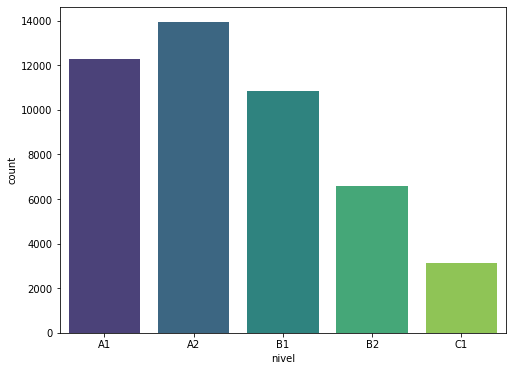

In [ ]:
# Gráfico de barras del número de registros por característica categorica
import seaborn as sb
plt.subplots(nrows = 1, ncols = 1, figsize =(8,6))
sb.countplot(x='nivel', data=corpus, orient='h', palette='viridis', order =['A1', 'A2', 'B1', 'B2', 'C1'])

## 2.2.Preparación del conjunto de datos
El objeto de esta sección es realizar los ajustes necesarios en el dataset para que pueda ser utilizado por las librerías de FastAI. Entre los aspectos a considerar se encuentran:
* Eliminación de las columnas que no son de interés para el problema de clasificación
* Adecuación de las características del dataset.

### 2.2.1.Eliminación características sin interés (para clasificación)

In [ ]:
# Eliminamos del dataset aquellas columnas (características) que no nos son de interés
corpus.drop('numero', inplace=True, axis=1)
corpus.drop('pClave', inplace=True, axis=1)
corpus.drop('archivo', inplace=True, axis=1)
corpus.drop('lenguaM', inplace=True, axis=1)
corpus.drop('Unnamed: 0', inplace=True, axis=1)

In [ ]:
# Mostrar la cabecera
corpus.head()

,nivel,frase
0,A1,"mi familia es solo 3 persona , me madre y me hermano y mi ."
1,B2,"La cuestión es que la propia temática ya nos ofrece la contestación , o_sea , Fumar en lugares PÚBLICOS ."
2,A2,"Nos ibe muchas luegos como museos , restaurantes , y parques ."
3,A1,"Entoncés , se puede que llego tarde ."
4,A1,"A mi me gusta el ballet clásico , escuchar música , salir de marcha y ser libre ."


In [ ]:
corpus.shape

(46787, 2)

In [ ]:
nRegInicial = corpus.shape[0]
nRegInicial

46787

### 2.2.2.Codificación valores únicos de nivel
* Codificación de la variable categórica "nivel" mediante el diccionario de conversión **nivel_mapping** definido en la sección, cuya codificación es la siguiente: **A1** = 0, **A2** = 1, **B1** = 2, **B2** = 3 y **C1** = 4 
* Eliianción de la columna  "nivel". Dejamos solo "label"
* Cambio del nombre de la columna "frase" -> "text" (requisito FastAI)

In [ ]:
# Convertimos la variable "nivel" en numerica ordenada, estableciendo nosotros el orden que queremos de forma similar a OrdinalEncoder
nivel_mapping = {
    'A1' : 0,
    'A2' : 1,
    'B1' : 2,
    'B2' : 3,
    'C1' : 4
}

corpus['label'] = corpus.nivel.map(nivel_mapping)
corpus

,nivel,frase,label
0,A1,"mi familia es solo 3 persona , me madre y me hermano y mi .",0
1,B2,"La cuestión es que la propia temática ya nos ofrece la contestación , o_sea , Fumar en lugares PÚBLICOS .",3
2,A2,"Nos ibe muchas luegos como museos , restaurantes , y parques .",1
3,A1,"Entoncés , se puede que llego tarde .",0
4,A1,"A mi me gusta el ballet clásico , escuchar música , salir de marcha y ser libre .",0
...,...,...,...
46782,B1,Señora Marquez,2
46783,B1,Estimado Señor / Señora,2
46784,B1,sinceramente,2
46785,A1,Sérgio,0


In [ ]:
# Eliminamos la columna nivel (nos quedamos con la codificación en label)
corpus.drop('nivel', inplace=True, axis=1)
corpus

,frase,label
0,"mi familia es solo 3 persona , me madre y me hermano y mi .",0
1,"La cuestión es que la propia temática ya nos ofrece la contestación , o_sea , Fumar en lugares PÚBLICOS .",3
2,"Nos ibe muchas luegos como museos , restaurantes , y parques .",1
3,"Entoncés , se puede que llego tarde .",0
4,"A mi me gusta el ballet clásico , escuchar música , salir de marcha y ser libre .",0
...,...,...
46782,Señora Marquez,2
46783,Estimado Señor / Señora,2
46784,sinceramente,2
46785,Sérgio,0


In [ ]:
# Renombramos la columna "frase" por "text" debido a requerimientos FastAI
corpus= corpus.rename(columns={"frase": "text"})

## 2.3.Segmentación Data Train + Data Test
Disponemos del dataset **corpus** con dos características (label, text) cargado y preparado.

El objeto de esta sección es realizar una segmentación del dataset para separar el conjunto de Train y el de Test, de forma que la validación la podamos hacer con un conjunto de datos sin manipular y con la misma estratificación, para que sea lo más real posible y podamos verificar si se produce Overfitting o no.
Ambos conjuntos ya tienen hechos los preparativos (codificación) y ajuste de los nombres de las características que deberán llevarse a cabo en caso de obtenerse nuevos datos. El cobjunto de Test se reserva para que no se vea afectado por posibles operaciones destinadas al balanceo de clases de forma que el conjunto de test corresponda fielmente a una muestra real, sin manipulación.

La Fragmentación se lleva a cabo con teniendo en cuenta tres aspectos importantes: **Primero**, debe ser estratificada, es decir cada una de las dos partes ha de conservar la proporción de valores de la clase del dataset, **Segundo**, ha de realizar un mezclado aleatorio de los registros y **Tercero** se ha de realizar con las proporciones indicadas (en principio 80% conjunto de Train y 20% conjunto de Test), aunque podrían probarse otras combinaciones.

* Fragmentamos corpus = Train + Test
* Reservamos Test

In [ ]:
from sklearn.model_selection import train_test_split
# Obtener la columna target para establecer la proporción en la segmentación
y1 = corpus['label'].values

# Segmentación Train + Test (80/20, estatificada y reordenación aleatoria)
corpus_train_val, corpus_test = train_test_split(corpus, test_size=0.20, random_state=seed, shuffle=True, stratify = y1)

In [ ]:
# Salvamos el dataset (para poderlo utilizar en caso de que no queramos balanceado)
df0 = corpus_train_val

In [ ]:
# Información Conjunto Train/Val
print(corpus_train_val['label'].value_counts())
print(corpus_train_val.shape[0])

1    11141
0     9827
2     8678
3     5281
4     2502
Name: label, dtype: int64
37429


In [ ]:
# Información Conjunto Test
print(corpus_test['label'].value_counts())
print(corpus_test.shape[0])

1    2785
0    2457
2    2170
3    1320
4     626
Name: label, dtype: int64
9358


#3.Balanceado del Dataset

Vista la distribución de clases del dataset (train_val, porque el conjunto de Test no se ha de tocar), se concluye que están manifiéstamente desbalanceadas, sobre todo en las clases correspondienrtes a los niveles más altos de la clasificación (B2 y C1). Respecto a los niveles más bajos (A1, A2 y B1), se observa que, aún existiendo diferencias de recuento entre ellos, podríamos considerar que se encuentran más o menos balanceados.
Al objeto de determinar si el balanceado de las clases puede afectar al rendimiento del modelo de clasificación, se plantea llevar a cabo un balanceado del mismo siguiendo dos técnicas:
* 1.- Upsampling de las clases minoritarias (B2 y C1) hasta conseguir equipararlas en observaciones a la media de las 3 clases mayoritarias (9.882 observaciones). Esto supone un enorme incremento de las mismas y supondría alterar 3 de las 5 clases (tambíen la B1). Con objeto de alterar lo menos posible los datos reales obtenidos, se decide homologar las clases minoritarias a la más baja de las mayoritarias, es decir B1 con 8.678 observaciones. Ha de tenerse en cuenta que ésta opción, si bien equilibra las clases minoritarias, no es un balanceado perfecto del dataset.

* 2.- En la segunda prueba, lo que buscaremos es homogeneizar el recuento en todas las clases. Para ello emplearemos una técnica mixta que supondrá el mismo upsampling para las clases minoritarias (B2 C1) ya realizado en el caso anterior unido al downsampling de las dos mayoritarias (A1 y A2) hasta homogeneizarlos al recuento de B1. Con ello conseguimos un verdadero balanceado, pero con mayor alteración del conjunto inicial.

Dependiendo de alguna de las actuaciones mejora los resultados obtenidos, podríamos replantearnos la opción de realizar en el caso del oversampling, en vez de la repetición aleatoria de instancias, la sintetización de nuevas instancias

In [ ]:
from sklearn.utils import resample
df = corpus_train_val
# Determinamos el número que determina el balanceado.
# Igualamos al nivel de la clase B1=2 (10848) tanto en Upsampling como Downsampling
regSample = df[df.label==2].shape[0]

## 3.1.Upsamplig Clases minoritarias (df)


In [ ]:
# Fraccionar el dataset, aislando las clases minoritarias: df => dfB2 y dfC1
# Clase B2 = 3
dfB2 = df[df.label==3]
nB2before = dfB2.shape[0]
print(f'Nº registros Inicial clase B2: {nB2before}')
# Clase C1 = 4
dfC1 = df[df.label==4]
nC1before = dfC1.shape[0]
print(f'Nº registros Inicial clase C1: {nC1before}')

Nº registros Inicial clase B2: 5281
Nº registros Inicial clase C1: 2502


In [ ]:
# Realizamos el upsampling de la clase minoritaria  B2:
dfB2plus = resample(dfB2, 
                    replace=True,     
                    n_samples=regSample,    
                    random_state=seed)
nB2after = dfB2plus.shape[0]
print(f'Clase B2: Nº Registros ANTES: {nB2before} - Nº Registros TRAS Upsampling: {nB2after}')

Clase B2: Nº Registros ANTES: 5281 - Nº Registros TRAS Upsampling: 8678


In [ ]:
# Realizamos el Upsampling de la clase minoritaria  C1:
dfC1plus = resample(dfC1, 
                    replace=True,     
                    n_samples=regSample,    
                    random_state=seed)
nC1after = dfC1plus.shape[0]
print(f'Clase C2: Nº Registros ANTES: {nC1before} - Nº Registros TRAS Upsampling: {nC1after}')

Clase C2: Nº Registros ANTES: 2502 - Nº Registros TRAS Upsampling: 8678


In [ ]:
# Componemos de nuevo el dataset con las clases minoritarias balanceadas con Upsampling
# Para ello:
# 1.- Eliminamos las filas de las clases a trabajar (B2 = 3 y C1 = 4)
# 2.- Al dataset obtenido le añadimos los dos dataset upsampled
niveles = [3, 4]

print(df.shape)
print(df['label'].value_counts())

for nv in niveles:
  df = df.drop(df[df['label']==nv].index)

df = pd.concat([df, dfB2plus, dfC1plus])
print(df.shape)
print(df['label'].value_counts())

(37429, 2)
1    11141
0     9827
2     8678
3     5281
4     2502
Name: label, dtype: int64
(47002, 2)
1    11141
0     9827
2     8678
3     8678
4     8678
Name: label, dtype: int64


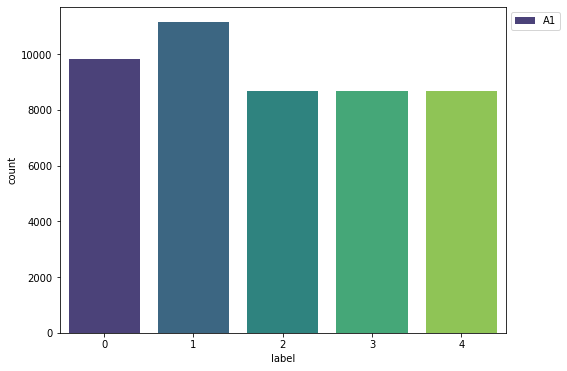

In [ ]:
# Gráfico de barras de registros por característica categorica tras upsampling minoritarias
plt.subplots(nrows = 1, ncols = 1, figsize =(8,6))
sb.countplot(x='label', data=df, orient='h', palette='viridis', order =[0, 1, 2, 3, 4])
plt.legend(labels = ['A1', 'A2', 'B1', 'B2', 'C1'], loc = 2, bbox_to_anchor = (1,1))

## 3.2.Upsamplig Clases Minoritarias + Downsampling Clases Mayoritarias (df_)

In [ ]:
# Volvemos a tomar el corpus_train_val inicial
df_ = corpus_train_val
# Igualamos al nivel de la clase B1=2 (10848) tanto en Upsampling como Downsampling
regSample = df_[df_.label==2].shape[0]

In [ ]:
# Fraccionar el dataset, aislando todas las clases
df_A1 = df_[df_.label==0]
df_A2 = df_[df_.label==1]
df_B1 = df_[df_.label==2]
df_B2 = df_[df_.label==3]
df_C1 = df_[df_.label==4]

In [ ]:
# Upsampling de la clase minoritaria  B2:
df_B2plus = resample(df_B2, 
                    replace=True,     
                    n_samples=regSample,    
                    random_state=seed)

In [ ]:
# Upsampling de la clase minoritaria  C1:
df_C1plus = resample(df_C1, 
                    replace=True,     
                    n_samples=regSample,    
                    random_state=seed)

In [ ]:
# Downsampling de la clase mayoritaria  A1:
df_A1plus = resample(df_A1, 
                    replace=True,     
                    n_samples=regSample,    
                    random_state=seed)

In [ ]:
# Downsampling de la clase mayoritaria  A2:
df_A2plus = resample(df_A2, 
                    replace=True,     
                    n_samples=regSample,    
                    random_state=seed)

In [ ]:
# Componemos de nuevo el dataset con las clases balanceadas a B1
# Son A1=0, A2=1, B2=3 y C1=4 

niveles = [0, 1, 3, 4]

print(df_.shape)
print(df_['label'].value_counts())

for nv in niveles:
  df_ = df_.drop(df_[df_['label']==nv].index)

df_ = pd.concat([df_A1plus, df_A2plus, df_, df_B2plus, df_C1plus])

print(df_.shape)
print(df_['label'].value_counts())

(37429, 2)
1    11141
0     9827
2     8678
3     5281
4     2502
Name: label, dtype: int64
(43390, 2)
0    8678
1    8678
2    8678
3    8678
4    8678
Name: label, dtype: int64


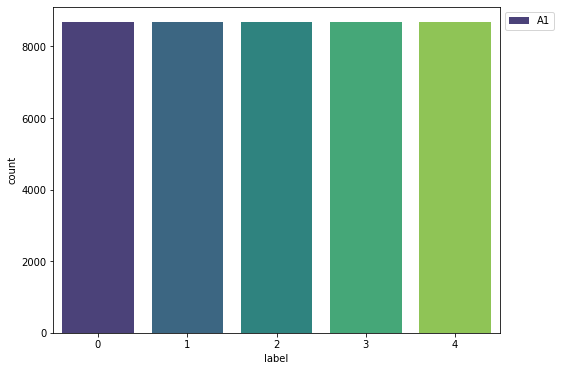

In [ ]:
# Gráfico de barras de registros por característica categorica tras upsampling minoritarias
plt.subplots(nrows = 1, ncols = 1, figsize =(8,6))
sb.countplot(x='label', data=df_, orient='h', palette='viridis', order =[0, 1, 2, 3, 4])
plt.legend(labels = ['A1', 'A2', 'B1', 'B2', 'C1'], loc = 2, bbox_to_anchor = (1,1))

# 4.Establecer Tipo de Balanceado de datos entrenamiento
Se han creado 3 datasets para poder realizar pruebas:
* **df0**: Dataset sin balancear
* **df**: Dataset semibalanceado (solo upsampling)
* **df_**: Dataset balanceado (upsamplig + downsampling)
Todos ellos son dataset de pruebas, en los que ahora debemos realizar la segmentación train/Validation

In [ ]:
# Para realizar las pruebas, tenemos que dar valor a corpus_train_val con uno de los dataset anteriores.
# Esta opción nos deja a corpus_test totalmente libre para poder realizar la verificación del modelo con datos reales
corpus_train_val=df0

# 5.Segmentación Train + Validation
Realizamos la segmentación del conjunto Train/Val, conservando las proporciones de estratificación existentes en el mismo (puede estar balanceado o no dependiendo del la elección en la sección anterior)
Separados los dos conjuntos, verificamos la correcta segmentación, añadimos una columna que nos permita diferenciarlos y volvemos a componer el conjunto unido (es requerimiento de la biblioteca FastAI)

In [ ]:
# Mantendremos en esta segmentación la estratificación del conjunto base (corpus_train_val)
# Nótese que es diferente dependiendo de el tipo de balanceado y que eso lo determinamos con y2
y2 = corpus_train_val['label'].values
corpus_train, corpus_valid = train_test_split(corpus_train_val, test_size=0.2, random_state=seed, shuffle=True, stratify = y2)

In [ ]:
# Información Conjunto Train
print(corpus_train['label'].value_counts())
print(corpus_train.shape[0])

1    8913
0    7861
2    6942
3    4225
4    2002
Name: label, dtype: int64
29943


In [ ]:
# Información Conjunto Valid
print(corpus_valid['label'].value_counts())
print(corpus_valid.shape[0])

1    2228
0    1966
2    1736
3    1056
4     500
Name: label, dtype: int64
7486


Juntamos ahora nuestro conjunto de entrenamiento y de validación. Para poder diferenciarlos vamos a añadir una columna a cada uno de ellos para indicar al conjunto al que pertenecen. La columna ``set`` va a tener dos valores: True si pertenece al conjunto de validación y False si pertenece al conjunto de test.

In [ ]:
corpus_train['is_valid']=False
corpus_valid['is_valid']=True

In [ ]:
# Juntamos los datasets Train + Validation
corpus_train_val = pd.concat([corpus_train, corpus_valid])
corpus_train_val

,text,label,is_valid
16995,"No , está las palabras cheat_fair .",2,False
28814,Vivimos en un país donde se permite humar cigarrillos y aún se paga altas tasas de impuestos .,3,False
3908,"Por eso , quiero seguir un programa academico en españa para mejorar mis competencias técnicas , comerciales y de compresión de la lengua y cultura españolas en_vista_de encontrar a empresas españolas .",3,False
43512,Puedes hacer guia proximo mes ?,2,False
38237,"Para obtener a visa para estudiar , ¿ necesito obtener un otra visa para trabajar a el mismo tiempo ?",3,False
...,...,...,...
40424,"Buenas tardes , me llamo Bárbara_Cunha y escribo con la intención de reservar una habitacíon para la ultima semana de noviembre de el año 2012 .",1,True
46585,Un abrazo Pedro,0,True
12229,"Soy simpatica y amable . tengo el pelo liso y largo , tengo los ojos marrones .",0,True
9750,su enfadado cliente .,4,True


In [ ]:
# Información Conjunto Train/Val
print(corpus_train_val['label'].value_counts())
print(corpus_train_val.shape[0])
print(corpus_train_val.shape)

1    11141
0     9827
2     8678
3     5281
4     2502
Name: label, dtype: int64
37429
(37429, 3)


In [ ]:
# Obtener información sobre cualquier función de fastAI
# Para que se vea mejor hay que instalar previamente
# pip install nbdev
doc(NLP.get_hf_objects)


# 6.Creación y entrenamiento de un modelo de clasificación (Transformers)

El proceso a seguir para hacer fine-tuning sobre el modelo de lenguaje de FastAI es análogo al visto en prácticas anteriores. Comenzamos creando un `DataBlock` a partir de nuestro dataframe. Sin embargo, para llevar a cabo esta tarea tenemos que definirlo a partir de los constructores de la librería Blurr.

## 6.1.Establecer Tipo de Tarea

In [ ]:
# Establecemos el tipo de modelo con el que vamos a trabajar (modelo de clasificación)
model_cls = AutoModelForSequenceClassification

## 6.2.Establecer Tipo de Modelo
A continuación debemos indicar el modelo que vamos a utilizar, ya que la creación de los `datablocks` es dependiente de esta elección. Por ejemplo [Bert](https://huggingface.co/bert-base-uncased), o cualquier otro de la lista disponible en Hugging Face

In [ ]:
# Fijar dentro del tipo, el modelo concreto. Probaremos los siguientes
# BERT (Google) ----------------------
# pretrained_model_name = "bert-base-uncased"
# pretrained_model_name = "bert-base-multilingual-uncased"
# pretrained_model_name = "bert-large-uncased"

# distilBERT  (HuggingFace) ----------
# pretrained_model_name = "distilbert-base-uncased"
# pretrained_model_name = "distilbert-base-multilingual-cased"

# XLNet (Google/CMU) -----------------
# pretrained_model_name = "xlnet-base-cased"

# XLM (Facebook) ---------------------
pretrained_model_name = "xlm-roberta-base"
# pretrained_model_name = "xlm-clm-enfr-1024"

# RoBERTa (Facebook) -----------------
# pretrained_model_name = "roberta-base"
# pretrained_model_name = "distilroberta-base"

# ALBERT -----------------------------
# pretrained_model_name = "albert-base-v2"

# GPT-2 ------------------------------
# pretrained_model_name = "optimum/gpt2"
# pretrained_model_name = "gpt2"
# pretrained_model_name = "gpt2-medium"
# pretrained_model_name = "gpt2-large"
# pretrained_model_name = "gpt2-xl"
# pretrained_model_name = "openai-gpt2"

# Spanish Language Models ------------
# pretrained_model_name = "bertin-project/bertin-roberta-base-spanish"
# pretrained_model_name = "dccuchile/bert-base-spanish-wwm-uncased" # BETO = Spanish BERT
# pretrained_model_name = "PlanTL-GOB-ES/roberta-base-bne"
# pretrained_model_name = "DeepESP/gpt2-spanish"

## 6.3.Determinar número de clases del problema

In [ ]:
# Obtener los distintos valores de las etiquetas
labels = list(corpus_train_val['label'].unique())
labels

[2, 3, 4, 1, 0]

In [ ]:
# Obtener la cuenta de las etiquetas distintas
n_labels = len(labels)
n_labels

5

In [ ]:
# Existen dos formas de indicar eso. Una es utilizar una clase de configuración (caso actual), la otra es indicarlo en los parámetros (caso prácticas)
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = n_labels

In [ ]:
config

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

## 6.4.Generar componentes del Modelo de Clasificación
Por último generamos varias componentes que son necesarias para entrenar nuestro modelo y que son dependientes del modelo que elijamos:
* La arquitectura del modelo.
* La configuración del modelo.
* El tokenizer.
* El modelo de huggingface. 

In [ ]:
# Carga de todos los objetos huggingface que son necesarios para entrenar el modelo. Se precisa: 1) Arquitectura, 2) Configuración, 3) Tokenizador y 4)Modelo
# La carga de todos los objetos se hace con una unica función. Pero ha de tenerse en cuenta que todos ellos son dependientes del tipo de modelo que se le pase
# como argumento. De ese modo si se elige el modelo BERT (para tareas de clasificación) el tokenizer y la configuración serán adecuadas a esa elección inicial y
# por tanto diferentes si se elige otro de los modelos. También es importante en los modelos de clasificación proporcionar el número de clases diferentes.

# Todo esto lo tiene empaquetado la libreria huggingface en una única función de la familia NLP, en este caso concreto la get_hf_objects

hf_arch, hf_config, hf_tokenizer,hf_model = NLP.get_hf_objects(
    pretrained_model_name,model_cls= model_cls, config=config
)

hf_arch, type(hf_config), type(hf_tokenizer),type(hf_model)

('xlm_roberta',
 transformers.models.xlm_roberta.configuration_xlm_roberta.XLMRobertaConfig,
 transformers.models.xlm_roberta.tokenization_xlm_roberta_fast.XLMRobertaTokenizerFast,
 transformers.models.xlm_roberta.modeling_xlm_roberta.XLMRobertaForSequenceClassification)

In [ ]:
hf_tokenizer

XLMRobertaTokenizerFast(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})

In [ ]:
hf_tokenizer.pad_token

'<pad>'

In [ ]:
# Define PAD Token = EOS Token = 50256
#hf_tokenizer.pad_token = hf_tokenizer.eos_token


In [ ]:
#if hf_tokenizer.pad_token is None:
#  hf_tokenizer.add_special_tokens({'pad_token': '<pad>'})
#  hf_model.resize_token_embeddings(len(hf_tokenizer))

In [ ]:
hf_tokenizer

XLMRobertaTokenizerFast(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})

## 6.5.Configuración del DataBlock
Con todos los componentes anteriores, procedemos a crear la configuración de nuesto `datablock`, para ello vamos a usar, inicialmente, la configuración por defecto del modelo que hemos seleccionado pero cambiaremos el número de posibles clases de nuestro problema (en este caso 5)

In [ ]:
# Convertir el dataset corpus_train_val (es un dataframe Pandas) en dataset HF para continuar
from datasets import Dataset
procs_ds = Dataset.from_pandas(corpus_train_val)
procs_ds

Dataset({
    features: ['text', 'label', 'is_valid', '__index_level_0__'],
    num_rows: 37429
})

In [ ]:
procs_ds.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'is_valid': Value(dtype='bool', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

### 6.5.1.Preprocesado del dataset
Preprocesado del dataset con el modelo que vamos a usar para aplicarle todas las funciones de "tokenización" precisadas antes de incluirlo en el DataBlock.
Notar que debemos indicar el atributo donde se encuentran las frases de nuestro dataset (en este caso ``text``).

In [ ]:
# Con todas las funciones anteriores se procede a realizar un preprocesado del dataset previo a la construcción del DataBlock. Es lo que se llaman PRE-TOKENIZADO
# Para ello se crea un objeto "preprocessor" con las funciones obtenidas (dependientes del modelo) y con el, se trabaja el dataset
# para adecuarlo a los pasos posteriores. Como vemos, el preprocesado devuelve un dataset transformado con columnas adicionales al original.
# En concreto presenta una serie de columnas adicionales como:
# --Transformado de la columna del texto (se le ha indicado en los parámetros cual es esa columna)
# --La codificación de la etiqueta original
# --La posición inicial del texto
# --La posición final del texto 
preprocessor = ClassificationPreprocessor(hf_tokenizer,label_mapping=labels,text_attr='text')
ds = preprocessor.process_hf_dataset(procs_ds)
ds


Dataset({
    features: ['proc_text', 'text', 'label', 'is_valid', '__index_level_0__', 'label_name', 'text_start_char_idx', 'text_end_char_idx'],
    num_rows: 37429
})

In [ ]:
# convertir el dataset (HF) a un dataframe (Pd) para visualizar el dataset transformado
import pandas as pd
df1 = pd.DataFrame( ds )
df1

,proc_text,text,label,is_valid,__index_level_0__,label_name,text_start_char_idx,text_end_char_idx
0,"No , está las palabras cheat_fair .","No , está las palabras cheat_fair .",2,False,16995,4,0,36
1,Vivimos en un país donde se permite humar cigarrillos y aún se paga altas tasas de impuestos .,Vivimos en un país donde se permite humar cigarrillos y aún se paga altas tasas de impuestos .,3,False,28814,1,0,94
2,"Por eso , quiero seguir un programa academico en españa para mejorar mis competencias técnicas , comerciales y de compresión de la lengua y cultura españolas en_vista_de encontrar a empresas españolas .","Por eso , quiero seguir un programa academico en españa para mejorar mis competencias técnicas , comerciales y de compresión de la lengua y cultura españolas en_vista_de encontrar a empresas españolas .",3,False,3908,1,0,202
3,Puedes hacer guia proximo mes ?,Puedes hacer guia proximo mes ?,2,False,43512,4,0,31
4,"Para obtener a visa para estudiar , ¿ necesito obtener un otra visa para trabajar a el mismo tiempo ?","Para obtener a visa para estudiar , ¿ necesito obtener un otra visa para trabajar a el mismo tiempo ?",3,False,38237,1,0,101
...,...,...,...,...,...,...,...,...
37424,"Buenas tardes , me llamo Bárbara_Cunha y escribo con la intención de reservar una habitacíon para la ultima semana de noviembre de el año 2012 .","Buenas tardes , me llamo Bárbara_Cunha y escribo con la intención de reservar una habitacíon para la ultima semana de noviembre de el año 2012 .",1,True,40424,3,0,144
37425,Un abrazo Pedro,Un abrazo Pedro,0,True,46585,2,0,15
37426,"Soy simpatica y amable . tengo el pelo liso y largo , tengo los ojos marrones .","Soy simpatica y amable . tengo el pelo liso y largo , tengo los ojos marrones .",0,True,12229,2,0,79
37427,su enfadado cliente .,su enfadado cliente .,4,True,9750,0,0,21


### 6.5.2.Identificar el conjunto de validación (en el dataset)
Hasta el momento lo veníamos haciendo mediante la introducción de un columna nueva que admitia dos valores, cada uno de los cuales representando a uno de los dos conjuntos. Pero en este caso, lo hacemos obteniendo el conjunto de índices del dataset que corresponde al conjunto de validación.

In [ ]:
# Establecemos los registros del dataset que corresponden al conjunto de validación
# Se hace mediante la extracción de la lista de índices del dataset que corresponden al conjunto de validación usando la etiqueta "is_valid" = True
# Para confirmarlo, se muestran el índice inferior y superior del conjunto total que determinan el conjunto de validación

val_idxs = [idx for idx,el in enumerate(ds) if el["is_valid"]==True]
min(val_idxs),max(val_idxs)

(29943, 37428)

In [ ]:
# Confirmar número de registros de Validación
len(val_idxs)

7486

## 6.6.Creación del DataBlock

In [ ]:
blocks = (
    TextBlock(
        hf_arch,
        hf_config,
        hf_tokenizer,
        hf_model,
        is_pretokenized=True,
        before_batch_kwargs={"labels":labels},
        tok_kwargs={"add_special_tokens":False}
    ),
    CategoryBlock
)

dblock = DataBlock(
    blocks=blocks,
    get_x=ItemGetter('text'), 
    get_y=ItemGetter('label'), 
    splitter=IndexSplitter(val_idxs)
)

## 6.7.Creación del DataLoader

In [ ]:
# Establecer el Batch Size
batchSize = 64

In [ ]:
%%time
dls = dblock.dataloaders(ds,bs=batchSize)

CPU times: user 25.9 s, sys: 110 ms, total: 26 s
Wall time: 26.1 s


In [ ]:
# Mostramos un batch del DataLoader
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"Pes estabamos en el kamra esperando un taxi de_repente pasó a+mi a+mi lado un homdre bien vestido preguntando la dirección+de dirección+de el hospita ibn_sina, de_repente se fue y me entere+qe entere+qe me habia+robado+la+cartera habia+robado+la+cartera habia+robado+la+cartera habia+robado+la+cartera",2
1,"Fuera estudiar, yo conocir muchos sitios buenissimos, Cerro_de_Santa_Lucia, La_Plaza_de_Armas, La_Plaza_Italia, la casa de Pablo_Neruda, conoci un metro y tambien fue esquiar en La_Parva.",1


## 6.8.Creación del Modelo

### 6.8.1.Definición de Métricas a utilizar

In [ ]:
# Definir métricas (No calculamos Recall y Precision porque no proporcionan información nueva - Solo accuracy y F1Score)
# recall_score = Recall(average ='weighted')
# precision_score = Precision(average ='weighted')
f1_score = F1Score(average ='weighted')
metrics = [accuracy, f1_score]

### 6.8.2.Establecimientos de Callbacks a utilizar

In [ ]:
# NOTA: Los callbacks, hasta ahora los hemos ubicado al crear el modelo, pero con los Transformers indica que alguna de las funciones 
#       no dispone de función de visualización y da error. Por ello, en la creación del modelo (learner) utilizamos el callback BaseModelCallback
#       y los de control del proceso de entrenamiento del modelo los añadimos en la función fine_tune (ahí si que funcionan)
#       El motivo por el que hay que hacer esto así no está claro, pero lo he obtenido de observar ejemplos.
#
# Adicionalmente, la función de mejora, en primcipio se mantiene el Valid_loss, pero es posible que pasemos a la accuracy.... veremos.

callbacks = [ShowGraphCallback(), SaveModelCallback(),  EarlyStoppingCallback(patience=5), ReduceLROnPlateau(patience = 1, min_lr = 1e-8)]

In [ ]:
# Cambiar la función de monitorización de la mejora del modelo
#callbacks = [ShowGraphCallback(),                                                  # Mostrar gráfico de entrenamiento
#             SaveModelCallback(monitor='accuracy'),                                # Guardado del mejor modelo
#             EarlyStoppingCallback((monitor='accuracy', patience=5),               # Parada anticipada si en 3 epoch no mejora la pérdida
#             ReduceLROnPlateau((monitor='accuracy', patience = 1, min_lr = 1e-8)]  # Reducción del LR si no se mejora en una epoch

### 6.8.3.Creación del modelo clasificación basado en Transformers

In [ ]:
model = BaseModelWrapper(hf_model) # Creación del Transformers

learn = Learner(dls,               # Modelo de clasificación (cbs=[BaseModelCallback])
                model,
                metrics=metrics,
                cbs=[BaseModelCallback],
                splitter=blurr_splitter
                ).to_fp16()

In [ ]:
model

BaseModelWrapper(
  (hf_model): XLMRobertaForSequenceClassification(
    (roberta): XLMRobertaModel(
      (embeddings): XLMRobertaEmbeddings(
        (word_embeddings): Embedding(250002, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): XLMRobertaEncoder(
        (layer): ModuleList(
          (0): XLMRobertaLayer(
            (attention): XLMRobertaAttention(
              (self): XLMRobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): XLMRobertaSelfOutput(
  

In [ ]:
model.hf_model.classifier.dropout.p

0.1

In [ ]:
#model.hf_model.classifier.dropout.p=0.7

In [ ]:
model.hf_model.classifier.dropout.p

0.1

## 6.9.Entrenamiento del Modelo

### 6.9.1.Determinación del Learning Rate

SuggestedLRs(valley=6.30957365501672e-05)

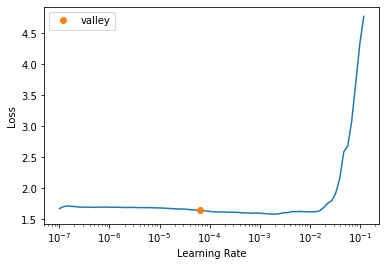

In [ ]:
# Determinamos el learning rate adecuado
learn.lr_find()
#suggested = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

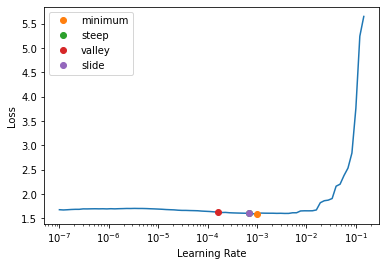

In [ ]:
suggested = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
suggested.valley

0.00015848931798245758

### 6.9.2.Ajuste Fino del Modelo

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.304327,1.172630,0.546620,0.526445,01:39


Better model found at epoch 0 with valid_loss value: 1.1726300716400146.


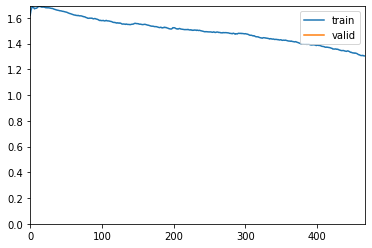

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.999289,0.828669,0.676062,0.675898,01:51
1,0.864841,0.753065,0.710393,0.709560,01:50
2,0.778400,0.709481,0.726423,0.725742,01:52
3,0.720573,0.700691,0.731365,0.730148,01:53
4,0.660985,0.673279,0.745124,0.744844,01:50
5,0.634508,0.652941,0.756078,0.755927,01:52
6,0.573900,0.655443,0.753273,0.751579,01:52
7,0.569805,0.629945,0.763158,0.762525,01:52
8,0.514829,0.642092,0.760887,0.761512,01:54
9,0.477061,0.664351,0.767433,0.766775,01:51


Better model found at epoch 0 with valid_loss value: 0.8286690711975098.


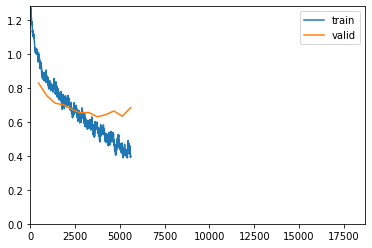

Better model found at epoch 1 with valid_loss value: 0.7530654072761536.
Better model found at epoch 2 with valid_loss value: 0.709481418132782.
Better model found at epoch 3 with valid_loss value: 0.7006914615631104.
Better model found at epoch 4 with valid_loss value: 0.6732791662216187.
Better model found at epoch 5 with valid_loss value: 0.6529410481452942.
Epoch 6: reducing lr to 5.573363751893939e-06
Better model found at epoch 7 with valid_loss value: 0.6299452185630798.
Epoch 8: reducing lr to 6.99480001794611e-06
Epoch 9: reducing lr to 7.498905971318751e-06
Epoch 10: reducing lr to 7.8159976710197e-06
Epoch 11: reducing lr to 7.92446540063616e-06
Epoch 12: reducing lr to 7.899658958759244e-06
No improvement since epoch 7: early stopping
CPU times: user 19min 50s, sys: 4min 9s, total: 24min
Wall time: 26min 46s


In [ ]:

%%time
learn.fine_tune(nEpochs, suggested.valley, cbs = callbacks)

In [ ]:
learn.validate()

(#3) [0.6299452185630798,0.7631579041481018,0.7625250591085905]

### 6.9.3.Almacenamiento del Modelo

In [ ]:
export_fname = 'seq_class_learn_export'
learn.export(fname=f'{export_fname}.pkl')

### 6.9.4.Predicción

In [ ]:
# De Nivel A1 - Portugués
learn.blurr_predict('Yo siento mucha falta de mi familia , de mi madre , de mi abuelo y de mis tías .')

[{'label': '0',
  'score': 0.8218823671340942,
  'class_index': 0,
  'class_labels': [0, 1, 2, 3, 4],
  'probs': [0.8218823671340942,
   0.12062083184719086,
   0.0416574664413929,
   0.0032618690747767687,
   0.01257750391960144]}]

In [ ]:
# De Nivel A2 - Árabe
learn.blurr_predict('El viaje estaba genial , hemos pasado buenas vacaciones este verano y estuvieron mejores que les de el año pasado .')

[{'label': '1',
  'score': 0.9814738631248474,
  'class_index': 1,
  'class_labels': [0, 1, 2, 3, 4],
  'probs': [0.001225695596076548,
   0.9814738631248474,
   0.017203452065587044,
   5.209456867305562e-05,
   4.4908323616255075e-05]}]

In [ ]:
# De Nivel B2 - Portugues
learn.blurr_predict('Vengo solicitar admisión en el programa de postgrado de lengua e literatura española de esta universidad .')

[{'label': '3',
  'score': 0.9979098439216614,
  'class_index': 3,
  'class_labels': [0, 1, 2, 3, 4],
  'probs': [0.0004584592243190855,
   0.0001538648211862892,
   0.001423490117304027,
   0.9979098439216614,
   5.4329040722223e-05]}]

In [ ]:
# De Nivel C1 - Ingles
learn.blurr_predict('Tuve un conversaciòn con su compañia durante el mes de septiembre y me dijeron que el precio por la electricidad serìa muy barato y por el telefono serìa solomente 20 E por cada mes .')


[{'label': '4',
  'score': 0.9997578263282776,
  'class_index': 4,
  'class_labels': [0, 1, 2, 3, 4],
  'probs': [6.6538603959998e-07,
   3.1073708669282496e-05,
   0.0001835048315115273,
   2.6944630008074455e-05,
   0.9997578263282776]}]

In [ ]:
# De Nivel A2
learn.blurr_predict('Es violinista , participa de grupos de música clásica y trabaja en un curso de fabricación de instrumientos musicales .')


[{'label': '1',
  'score': 0.9065711498260498,
  'class_index': 1,
  'class_labels': [0, 1, 2, 3, 4],
  'probs': [0.056861959397792816,
   0.9065711498260498,
   0.0022515584714710712,
   0.005749556235969067,
   0.028565824031829834]}]

## 6.10.Validación del Modelo

### 1.5.1.Preprocesado del dataset Train+Test

In [ ]:
#corpus_train['is_valid']=False
corpus_test['is_valid']=True

In [ ]:
# Juntamos los datasets Train + Test
corpus_train_test = pd.concat([corpus_train, corpus_test])

In [ ]:
# Renombramos la columna de texto por requerimiento de FastAI
corpus_train_test = corpus_train_test.rename(columns={"frase": "text"})
corpus_train_test

,text,label,is_valid
16995,"No , está las palabras cheat_fair .",2,False
28814,Vivimos en un país donde se permite humar cigarrillos y aún se paga altas tasas de impuestos .,3,False
3908,"Por eso , quiero seguir un programa academico en españa para mejorar mis competencias técnicas , comerciales y de compresión de la lengua y cultura españolas en_vista_de encontrar a empresas españolas .",3,False
43512,Puedes hacer guia proximo mes ?,2,False
38237,"Para obtener a visa para estudiar , ¿ necesito obtener un otra visa para trabajar a el mismo tiempo ?",3,False
...,...,...,...
30876,En estas ultimas vacaciones me he divertido mucho y todavia no he hecho nada de muy especial .,1,True
34783,"También , ¿ Como es la estructura de el programa ?",3,True
12039,Espero ver les pronto .,0,True
3076,"Enctonces , cuando los leyes se impusieron contra fumar en lugares publicos , me lo agredecio .",3,True


In [ ]:
# Realizado el preprocesado de los datos (segmentación Train/Validation) en un dataframe Pandas (corpus_train_valid), convertimos el mismo a un dataset (HF)
from datasets import Dataset
procs_ds_test = Dataset.from_pandas(corpus_train_test)
procs_ds_test

Dataset({
    features: ['text', 'label', 'is_valid', '__index_level_0__'],
    num_rows: 39301
})

In [ ]:
ds_test = preprocessor.process_hf_dataset(procs_ds_test)

test_idxs = [idx for idx,el in enumerate(ds_test) if el["is_valid"]==True]

dblock_test = DataBlock(
    blocks=blocks,
    get_x=ItemGetter('text'), 
    get_y=ItemGetter('label'), 
    splitter=IndexSplitter(test_idxs)
)


### 1.5.2.Validación

In [ ]:
dls_test = dblock_test.dataloaders(ds_test, bs=batchSize)
learn.dls = dls_test
learn.validate()

(#3) [0.6294501423835754,0.7634109854698181,0.7624644582492935]

### 1.5.3.Matriz de Confusión del modelo

In [ ]:
interp_test = ClassificationInterpretation.from_learner(learn)

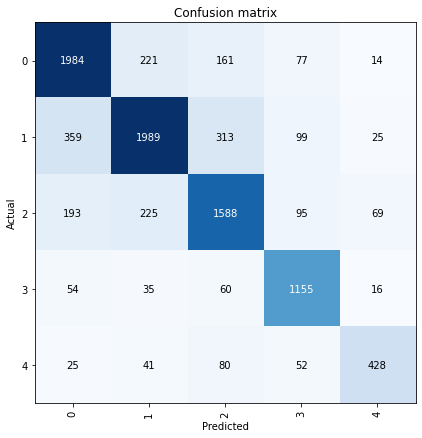

In [ ]:
# Calcular la matriz de confusión sobre el conjunto de test
interp_test.plot_confusion_matrix(figsize=(10,6))

### 1.5.4.Predicciones modelos (gráficas)

In [ ]:
# Función para crear una gráfica de barras a partir de las predicciones
import matplotlib.pyplot as plt
def prediccion(valores):
    clases = ["A1", "A2", "B1", "B2", "C1"] # Items de la grafica
    indexMx = valores.index(max(valores))
    colors= ['lightgreen','lightgreen', 'lightgreen','lightgreen', 'lightgreen'] # Colores de los items
    colors[indexMx]= 'green'
    plt.bar(clases, valores, color=colors) # asignar items, valores y colores a la grafica
    plt.title('Predicción') # colocar un titulo a la grafica
    plt.xlabel('Clases') # Poner un titulo o etiqueta a el Eje X
    plt.ylabel('Probabilidad') # Poner un titulo o etiqueta a el Eje Y
    plt.show() # Mostrar la grafica

In [ ]:
# Establecer el directorio en el que se guarde el modelo y el nombre (siempre sin extensión)
#path ='/content/drive/MyDrive/ModeloEjemplo/'
#model_name = path+'DistilBERT-Clasificacion70'
#model_name

# Importación del modelo guardado en disco
#Mylearn = load_learner(f'{model_name}.pkl')
# De Nivel A2 - Árabe
# prediccion(Mylearn.blurr_predict('El viaje estaba genial , hemos pasado buenas vacaciones este verano y estuvieron mejores que les de el año pasado .')[0]["probs"])

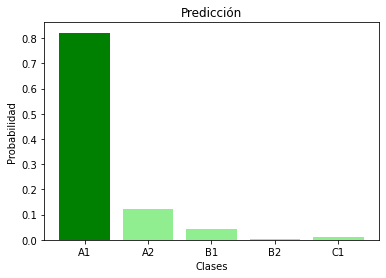

In [ ]:
# De Nivel A1 - Portugués
prediccion(learn.blurr_predict('Yo siento mucha falta de mi familia , de mi madre , de mi abuelo y de mis tías .')[0]["probs"])

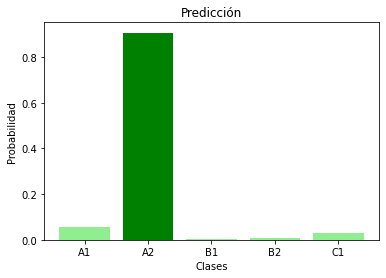

In [ ]:
# De Nivel A2
prediccion(learn.blurr_predict('Es violinista , participa de grupos de música clásica y trabaja en un curso de fabricación de instrumientos musicales .')[0]["probs"])

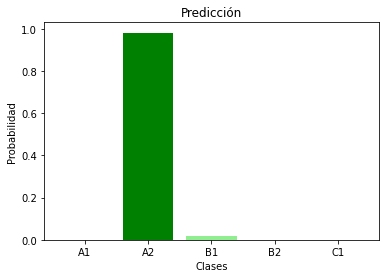

In [ ]:
# De Nivel A2 - Árabe
prediccion(learn.blurr_predict('El viaje estaba genial , hemos pasado buenas vacaciones este verano y estuvieron mejores que les de el año pasado .')[0]["probs"])

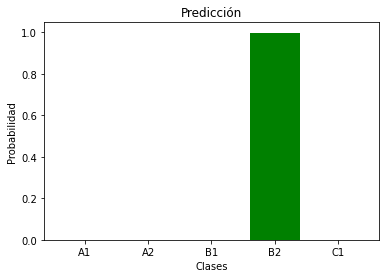

In [ ]:
# De Nivel B2 - Portugues
prediccion(learn.blurr_predict('Vengo solicitar admisión en el programa de postgrado de lengua e literatura española de esta universidad .')[0]["probs"])

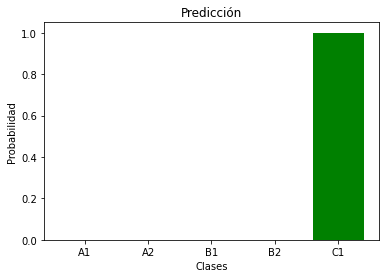

In [ ]:
# De Nivel C1 - Ingles
prediccion(learn.blurr_predict('Tuve un conversaciòn con su compañia durante el mes de septiembre y me dijeron que el precio por la electricidad serìa muy barato y por el telefono serìa solomente 20 E por cada mes .')[0]["probs"])


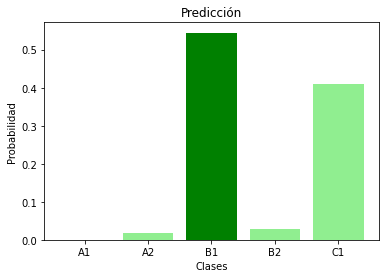

In [ ]:
# Cervantes
Texto ='En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. '
prediccion(learn.blurr_predict(Texto)[0]["probs"])

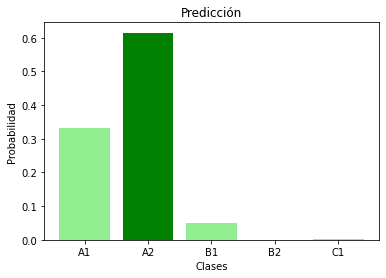

In [ ]:
# Texto A2 en Español
Texto ='He comido tarde, más o menos a las cuatro, en “Bar Pepe”, que está debajo de mi casa. El dueño, Pepe, es muy amable y el sitio es muy confortable. Además, es muy barato. He comido un bocadillo de atún y huevo que es mi preferido.'
prediccion(learn.blurr_predict(Texto)[0]["probs"])